In [1]:
import random
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
from predict import load_trained_model, predict_image_class
from data_preparation import get_cifar10_datasets, get_dataloader
from train import train_model

# Functions

In [3]:
def plot_triplet_images(image_label_tuple, index_to_class_mapping):
    """
    Plots a row of 3 CIFAR-10 images with labels.

    Args:
        image_label_tuple (tuple): A tuple of (images, labels) where:
            - images is a list or tensor of 3 images
            - labels is a list or tensor of 3 corresponding labels
        index_to_class_mapping (dict): Mapping from class index to class name
    """
    images, labels = image_label_tuple
    assert len(images) == 3

    label_title = ['anchor', 'positive', 'negative']
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    for i in range(3):
        img, label = images[i], labels
        if i == 2:
            display_label = 'other'
        else:
            display_label = index_to_class_mapping[label]

        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
            if img.shape[0] == 3:  # (C, H, W)
                img = img.permute(1, 2, 0)  # to (H, W, C)
        
        axs[i].imshow(img)
        axs[i].set_title(label_title[i] + ': ' + display_label, fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def show_image(image_tensor, title=None):
    assert isinstance(image_tensor, torch.Tensor), "Input must be a torch.Tensor"
    assert image_tensor.shape == (3, 32, 32), "Image must be of shape (3, 32, 32)"

    # Move to CPU, detach, and convert to numpy
    img = image_tensor.detach().cpu()
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # Rescale from normalized range [-1, 1] or other to [0, 1] if needed
    img = (img - img.min()) / (img.max() - img.min())

    # Plot the image
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


In [5]:
def reduce_dimension_pca(embeddings: np.ndarray, target_dim: int = 2) -> np.ndarray:
    pca = PCA(n_components=target_dim)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

In [6]:
def sample_per_class(data: np.ndarray, labels: np.ndarray, num_samples_per_class: int):
    unique_classes = np.unique(labels)
    sampled_indices = []

    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]

        num_to_sample = min(num_samples_per_class, len(class_indices))

        sampled_class_indices = np.random.choice(class_indices, size=num_to_sample, replace=False)

        sampled_indices.extend(sampled_class_indices)

    sampled_indices = np.array(sampled_indices)
    np.random.shuffle(sampled_indices)

    sampled_data = data[sampled_indices]
    sampled_labels = labels[sampled_indices]

    return sampled_data, sampled_labels

# Dataset

In [7]:
CLASS_INDEX = [0, 1, 2, 3]
CLASS_LABEL = ['cat', 'dog', 'ship', 'truck']
LABEL_MAP = {original_label: new_label for new_label, original_label in enumerate(CLASS_INDEX)}
INDEX_TO_CLASS = {i: j for i, j in zip(CLASS_INDEX, CLASS_LABEL)}

In [8]:
train_dataset, test_dataset = get_cifar10_datasets(data_dir='./data')
train_loader, test_loader = get_dataloader(train_dataset, test_dataset, batch_size=128, num_workers=8)

Filtering and remapping base training dataset...
Dataset filtered. New number of samples: 20000
Filtering and remapping base testing dataset...
Dataset filtered. New number of samples: 4000
Triplet Dataset created with 20000 samples (based on base dataset size).
Classes found in dataset: [0, 1, 2, 3]
Filtered CIFAR-10 Triplet train loader and standard test loader created with 8 workers.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.6952004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.1489122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.4220564].


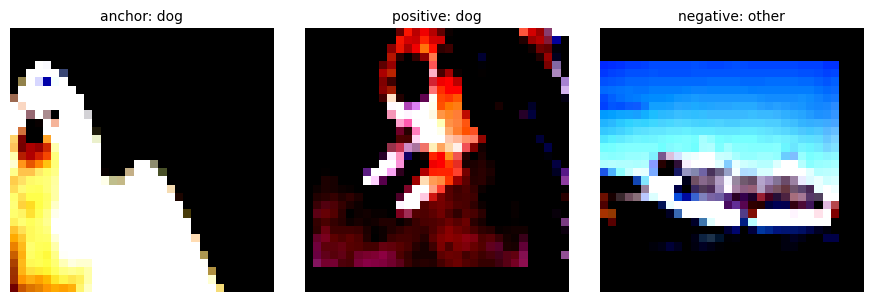

In [9]:
plot_triplet_images(train_dataset[random.randint(0, 20000)], INDEX_TO_CLASS)

# Training

In [10]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='cnn',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=0.5,
    triplet_weight=1,
    classification_weight=0.5,
)

Using device: mps
learning_rate: 0.0005, 
num_epochs: 12 
embedding_dim: 128 
num_classes: 4
Encoder Architecture: cnn
Triplet Margin: 0.5, Triplet Weight: 1, Classification Weight: 0.5
Starting training...


Epoch 1/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=4.4865] 



Epoch [1/12] Summary: Total Train Loss: 0.7835, Clf Train Loss: 0.9662, Trip Train Loss: 0.3004, Train Acc: 56.20%, Test Loss: 0.6820, Test Acc: 66.83% 




Epoch 2/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=3.2217] 



Epoch [2/12] Summary: Total Train Loss: 0.5594, Clf Train Loss: 0.6697, Trip Train Loss: 0.2245, Train Acc: 68.55%, Test Loss: 0.6443, Test Acc: 71.35% 




Epoch 3/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=3.0901] 



Epoch [3/12] Summary: Total Train Loss: 0.4942, Clf Train Loss: 0.5905, Trip Train Loss: 0.1990, Train Acc: 72.74%, Test Loss: 0.5686, Test Acc: 74.40% 




Epoch 4/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.6495] 



Epoch [4/12] Summary: Total Train Loss: 0.4556, Clf Train Loss: 0.5380, Trip Train Loss: 0.1866, Train Acc: 75.49%, Test Loss: 0.4875, Test Acc: 78.12% 




Epoch 5/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.2399] 



Epoch [5/12] Summary: Total Train Loss: 0.4333, Clf Train Loss: 0.5149, Trip Train Loss: 0.1758, Train Acc: 76.84%, Test Loss: 0.4480, Test Acc: 81.05% 




Epoch 6/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.6738] 



Epoch [6/12] Summary: Total Train Loss: 0.4041, Clf Train Loss: 0.4722, Trip Train Loss: 0.1680, Train Acc: 79.23%, Test Loss: 0.4920, Test Acc: 78.83% 




Epoch 7/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.5091] 



Epoch [7/12] Summary: Total Train Loss: 0.3914, Clf Train Loss: 0.4601, Trip Train Loss: 0.1614, Train Acc: 80.13%, Test Loss: 0.4617, Test Acc: 79.97% 




Epoch 8/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.2230]



Epoch [8/12] Summary: Total Train Loss: 0.3704, Clf Train Loss: 0.4345, Trip Train Loss: 0.1531, Train Acc: 81.14%, Test Loss: 0.4090, Test Acc: 82.50% 




Epoch 9/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.0960]



Epoch [9/12] Summary: Total Train Loss: 0.3705, Clf Train Loss: 0.4367, Trip Train Loss: 0.1522, Train Acc: 80.86%, Test Loss: 0.3857, Test Acc: 83.88% 




Epoch 10/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.3758] 



Epoch [10/12] Summary: Total Train Loss: 0.3498, Clf Train Loss: 0.4120, Trip Train Loss: 0.1438, Train Acc: 82.34%, Test Loss: 0.4752, Test Acc: 80.42% 




Epoch 11/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.1388]



Epoch [11/12] Summary: Total Train Loss: 0.3443, Clf Train Loss: 0.4039, Trip Train Loss: 0.1424, Train Acc: 82.60%, Test Loss: 0.3935, Test Acc: 83.30% 




Epoch 12/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.1984]



Epoch [12/12] Summary: Total Train Loss: 0.3269, Clf Train Loss: 0.3826, Trip Train Loss: 0.1356, Train Acc: 83.58%, Test Loss: 0.3869, Test Acc: 83.75% 


Training finished.
Plots saved to './output' directory.
Model parameters saved to './output/cnn_4cls_128dim_0.5tm_model.pth'


In [11]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='cnn',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

Using device: mps
learning_rate: 0.0005, 
num_epochs: 12 
embedding_dim: 128 
num_classes: 4
Encoder Architecture: cnn
Triplet Margin: 1, Triplet Weight: 1, Classification Weight: 0.5
Starting training...


Epoch 1/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=4.4904] 



Epoch [1/12] Summary: Total Train Loss: 1.0403, Clf Train Loss: 0.9235, Trip Train Loss: 0.5786, Train Acc: 57.58%, Test Loss: 0.6825, Test Acc: 67.95% 




Epoch 2/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=3.1062] 



Epoch [2/12] Summary: Total Train Loss: 0.7772, Clf Train Loss: 0.6689, Trip Train Loss: 0.4427, Train Acc: 68.25%, Test Loss: 0.5715, Test Acc: 72.62% 




Epoch 3/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=3.2663] 



Epoch [3/12] Summary: Total Train Loss: 0.6964, Clf Train Loss: 0.5949, Trip Train Loss: 0.3990, Train Acc: 71.67%, Test Loss: 0.5487, Test Acc: 75.83% 




Epoch 4/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.7573] 



Epoch [4/12] Summary: Total Train Loss: 0.6560, Clf Train Loss: 0.5610, Trip Train Loss: 0.3755, Train Acc: 74.24%, Test Loss: 0.5073, Test Acc: 75.95% 




Epoch 5/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.5220] 



Epoch [5/12] Summary: Total Train Loss: 0.6101, Clf Train Loss: 0.5225, Trip Train Loss: 0.3489, Train Acc: 76.62%, Test Loss: 0.4640, Test Acc: 79.25% 




Epoch 6/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.4404] 



Epoch [6/12] Summary: Total Train Loss: 0.5768, Clf Train Loss: 0.4851, Trip Train Loss: 0.3343, Train Acc: 78.45%, Test Loss: 0.4490, Test Acc: 80.55% 




Epoch 7/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.6091] 



Epoch [7/12] Summary: Total Train Loss: 0.5673, Clf Train Loss: 0.4747, Trip Train Loss: 0.3300, Train Acc: 78.98%, Test Loss: 0.4801, Test Acc: 79.75% 




Epoch 8/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.3275] 



Epoch [8/12] Summary: Total Train Loss: 0.5400, Clf Train Loss: 0.4563, Trip Train Loss: 0.3118, Train Acc: 80.21%, Test Loss: 0.4283, Test Acc: 81.78% 




Epoch 9/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.2601]



Epoch [9/12] Summary: Total Train Loss: 0.5284, Clf Train Loss: 0.4419, Trip Train Loss: 0.3075, Train Acc: 80.61%, Test Loss: 0.4159, Test Acc: 81.97% 




Epoch 10/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.5360]



Epoch [10/12] Summary: Total Train Loss: 0.5077, Clf Train Loss: 0.4229, Trip Train Loss: 0.2963, Train Acc: 81.59%, Test Loss: 0.3855, Test Acc: 83.75% 




Epoch 11/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.4264] 



Epoch [11/12] Summary: Total Train Loss: 0.4867, Clf Train Loss: 0.4077, Trip Train Loss: 0.2829, Train Acc: 82.28%, Test Loss: 0.4464, Test Acc: 81.45% 




Epoch 12/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.0015]


Epoch [12/12] Summary: Total Train Loss: 0.4744, Clf Train Loss: 0.3931, Trip Train Loss: 0.2778, Train Acc: 82.88%, Test Loss: 0.3683, Test Acc: 84.25% 


Training finished.
Plots saved to './output' directory.
Model parameters saved to './output/cnn_4cls_128dim_1tm_model.pth'


In [12]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='cnn',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1.5,
    triplet_weight=1,
    classification_weight=0.5,
)

Using device: mps
learning_rate: 0.0005, 
num_epochs: 12 
embedding_dim: 128 
num_classes: 4
Encoder Architecture: cnn
Triplet Margin: 1.5, Triplet Weight: 1, Classification Weight: 0.5
Starting training...


Epoch 1/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=4.1066] 



Epoch [1/12] Summary: Total Train Loss: 1.3932, Clf Train Loss: 0.9449, Trip Train Loss: 0.9207, Train Acc: 55.41%, Test Loss: 0.7228, Test Acc: 64.62% 




Epoch 2/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=3.4035] 



Epoch [2/12] Summary: Total Train Loss: 1.0412, Clf Train Loss: 0.6908, Trip Train Loss: 0.6958, Train Acc: 67.13%, Test Loss: 0.5990, Test Acc: 73.10% 




Epoch 3/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it, loss=2.9049] 



Epoch [3/12] Summary: Total Train Loss: 0.9301, Clf Train Loss: 0.6170, Trip Train Loss: 0.6216, Train Acc: 71.94%, Test Loss: 0.5345, Test Acc: 75.17% 




Epoch 4/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it, loss=2.8658] 



Epoch [4/12] Summary: Total Train Loss: 0.8658, Clf Train Loss: 0.5754, Trip Train Loss: 0.5781, Train Acc: 73.62%, Test Loss: 0.5044, Test Acc: 78.00% 




Epoch 5/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.6832] 



Epoch [5/12] Summary: Total Train Loss: 0.8102, Clf Train Loss: 0.5303, Trip Train Loss: 0.5451, Train Acc: 76.38%, Test Loss: 0.4722, Test Acc: 79.17% 




Epoch 6/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it, loss=2.5971] 



Epoch [6/12] Summary: Total Train Loss: 0.7644, Clf Train Loss: 0.5003, Trip Train Loss: 0.5143, Train Acc: 77.56%, Test Loss: 0.4779, Test Acc: 79.62% 




Epoch 7/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it, loss=2.4944]



Epoch [7/12] Summary: Total Train Loss: 0.7447, Clf Train Loss: 0.4793, Trip Train Loss: 0.5051, Train Acc: 78.90%, Test Loss: 0.4390, Test Acc: 81.47% 




Epoch 8/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it, loss=2.6251] 



Epoch [8/12] Summary: Total Train Loss: 0.7172, Clf Train Loss: 0.4667, Trip Train Loss: 0.4838, Train Acc: 79.52%, Test Loss: 0.4620, Test Acc: 80.12% 




Epoch 9/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.3947] 



Epoch [9/12] Summary: Total Train Loss: 0.6999, Clf Train Loss: 0.4550, Trip Train Loss: 0.4724, Train Acc: 80.09%, Test Loss: 0.4406, Test Acc: 81.28% 




Epoch 10/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it, loss=2.5099]



Epoch [10/12] Summary: Total Train Loss: 0.6717, Clf Train Loss: 0.4301, Trip Train Loss: 0.4567, Train Acc: 81.21%, Test Loss: 0.4417, Test Acc: 82.12% 




Epoch 11/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.3047]



Epoch [11/12] Summary: Total Train Loss: 0.6528, Clf Train Loss: 0.4171, Trip Train Loss: 0.4443, Train Acc: 82.11%, Test Loss: 0.4241, Test Acc: 82.10% 




Epoch 12/12 [Test ]: 100%|██████████| 32/32 [00:50<00:00,  1.57s/it, loss=2.2097]



Epoch [12/12] Summary: Total Train Loss: 0.6269, Clf Train Loss: 0.4065, Trip Train Loss: 0.4237, Train Acc: 82.42%, Test Loss: 0.3889, Test Acc: 84.30% 


Training finished.
Plots saved to './output' directory.
Model parameters saved to './output/cnn_4cls_128dim_1.5tm_model.pth'


In [13]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='resnet18',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

Using device: mps
learning_rate: 0.0005, 
num_epochs: 12 
embedding_dim: 128 
num_classes: 4
Encoder Architecture: resnet18
Triplet Margin: 1, Triplet Weight: 1, Classification Weight: 0.5
Starting training...


Epoch 1/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.62s/it, loss=3.3308]



Epoch [1/12] Summary: Total Train Loss: 1.0006, Clf Train Loss: 0.8647, Trip Train Loss: 0.5683, Train Acc: 59.27%, Test Loss: 0.7727, Test Acc: 62.33% 




Epoch 2/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=3.0570]



Epoch [2/12] Summary: Total Train Loss: 0.7242, Clf Train Loss: 0.6476, Trip Train Loss: 0.4004, Train Acc: 69.31%, Test Loss: 0.7092, Test Acc: 66.33% 




Epoch 3/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.4324]



Epoch [3/12] Summary: Total Train Loss: 0.6210, Clf Train Loss: 0.5783, Trip Train Loss: 0.3318, Train Acc: 72.77%, Test Loss: 0.5643, Test Acc: 75.97% 




Epoch 4/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.4534]



Epoch [4/12] Summary: Total Train Loss: 0.5479, Clf Train Loss: 0.5072, Trip Train Loss: 0.2944, Train Acc: 76.92%, Test Loss: 0.5692, Test Acc: 74.80% 




Epoch 5/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.1173]



Epoch [5/12] Summary: Total Train Loss: 0.5024, Clf Train Loss: 0.4706, Trip Train Loss: 0.2671, Train Acc: 79.23%, Test Loss: 0.4912, Test Acc: 80.45% 




Epoch 6/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.5647]



Epoch [6/12] Summary: Total Train Loss: 0.4576, Clf Train Loss: 0.4392, Trip Train Loss: 0.2380, Train Acc: 81.52%, Test Loss: 0.5950, Test Acc: 77.05% 




Epoch 7/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.6523]



Epoch [7/12] Summary: Total Train Loss: 0.4181, Clf Train Loss: 0.3928, Trip Train Loss: 0.2217, Train Acc: 83.77%, Test Loss: 0.3833, Test Acc: 84.97% 




Epoch 8/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.6203]



Epoch [8/12] Summary: Total Train Loss: 0.3824, Clf Train Loss: 0.3698, Trip Train Loss: 0.1976, Train Acc: 84.75%, Test Loss: 0.3759, Test Acc: 85.38% 




Epoch 9/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.8330]



Epoch [9/12] Summary: Total Train Loss: 0.3555, Clf Train Loss: 0.3413, Trip Train Loss: 0.1848, Train Acc: 86.27%, Test Loss: 0.4253, Test Acc: 84.30% 




Epoch 10/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.5400]



Epoch [10/12] Summary: Total Train Loss: 0.3309, Clf Train Loss: 0.3213, Trip Train Loss: 0.1703, Train Acc: 86.89%, Test Loss: 0.3573, Test Acc: 85.95% 




Epoch 11/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.4008]



Epoch [11/12] Summary: Total Train Loss: 0.3150, Clf Train Loss: 0.3080, Trip Train Loss: 0.1610, Train Acc: 87.93%, Test Loss: 0.3250, Test Acc: 87.28% 




Epoch 12/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.6634]



Epoch [12/12] Summary: Total Train Loss: 0.2953, Clf Train Loss: 0.2945, Trip Train Loss: 0.1480, Train Acc: 88.35%, Test Loss: 0.3859, Test Acc: 85.30% 


Training finished.
Plots saved to './output' directory.
Model parameters saved to './output/resnet18_4cls_128dim_1tm_model.pth'


In [14]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='resnet18',
    embedding_dim=64,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

Using device: mps
learning_rate: 0.0005, 
num_epochs: 12 
embedding_dim: 64 
num_classes: 4
Encoder Architecture: resnet18
Triplet Margin: 1, Triplet Weight: 1, Classification Weight: 0.5
Starting training...


Epoch 1/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=3.3483]



Epoch [1/12] Summary: Total Train Loss: 1.0091, Clf Train Loss: 0.8814, Trip Train Loss: 0.5684, Train Acc: 58.08%, Test Loss: 0.7768, Test Acc: 62.00% 




Epoch 2/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=3.1564]



Epoch [2/12] Summary: Total Train Loss: 0.7023, Clf Train Loss: 0.6422, Trip Train Loss: 0.3812, Train Acc: 69.58%, Test Loss: 0.7323, Test Acc: 68.45% 




Epoch 3/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, loss=2.3253]



Epoch [3/12] Summary: Total Train Loss: 0.6064, Clf Train Loss: 0.5571, Trip Train Loss: 0.3279, Train Acc: 74.17%, Test Loss: 0.5395, Test Acc: 76.08% 




Epoch 4/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.2669]



Epoch [4/12] Summary: Total Train Loss: 0.5381, Clf Train Loss: 0.5027, Trip Train Loss: 0.2867, Train Acc: 77.61%, Test Loss: 0.5259, Test Acc: 77.83% 




Epoch 5/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, loss=1.8657]



Epoch [5/12] Summary: Total Train Loss: 0.4902, Clf Train Loss: 0.4610, Trip Train Loss: 0.2597, Train Acc: 80.07%, Test Loss: 0.4328, Test Acc: 81.45% 




Epoch 6/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.9411]



Epoch [6/12] Summary: Total Train Loss: 0.4378, Clf Train Loss: 0.4126, Trip Train Loss: 0.2315, Train Acc: 82.44%, Test Loss: 0.4503, Test Acc: 80.88% 




Epoch 7/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.8028]



Epoch [7/12] Summary: Total Train Loss: 0.4048, Clf Train Loss: 0.3838, Trip Train Loss: 0.2129, Train Acc: 84.20%, Test Loss: 0.4183, Test Acc: 83.75% 




Epoch 8/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.8299]



Epoch [8/12] Summary: Total Train Loss: 0.3743, Clf Train Loss: 0.3604, Trip Train Loss: 0.1941, Train Acc: 85.39%, Test Loss: 0.4245, Test Acc: 83.50% 




Epoch 9/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.4005]



Epoch [9/12] Summary: Total Train Loss: 0.3539, Clf Train Loss: 0.3374, Trip Train Loss: 0.1852, Train Acc: 86.20%, Test Loss: 0.5569, Test Acc: 79.95% 




Epoch 10/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.7178]



Epoch [10/12] Summary: Total Train Loss: 0.3307, Clf Train Loss: 0.3211, Trip Train Loss: 0.1701, Train Acc: 87.39%, Test Loss: 0.6305, Test Acc: 79.80% 




Epoch 11/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.6731]



Epoch [11/12] Summary: Total Train Loss: 0.3283, Clf Train Loss: 0.3137, Trip Train Loss: 0.1715, Train Acc: 87.45%, Test Loss: 0.3882, Test Acc: 85.85% 




Epoch 12/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, loss=1.4412]



Epoch [12/12] Summary: Total Train Loss: 0.2936, Clf Train Loss: 0.2867, Trip Train Loss: 0.1502, Train Acc: 88.43%, Test Loss: 0.3344, Test Acc: 87.80% 


Training finished.
Plots saved to './output' directory.
Model parameters saved to './output/resnet18_4cls_64dim_1tm_model.pth'


In [15]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='resnet18',
    embedding_dim=64,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1.5,
    triplet_weight=1,
    classification_weight=0.5,
)

Using device: mps
learning_rate: 0.0005, 
num_epochs: 12 
embedding_dim: 64 
num_classes: 4
Encoder Architecture: resnet18
Triplet Margin: 1.5, Triplet Weight: 1, Classification Weight: 0.5
Starting training...


Epoch 1/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=3.1313]



Epoch [1/12] Summary: Total Train Loss: 1.2731, Clf Train Loss: 0.8725, Trip Train Loss: 0.8368, Train Acc: 59.16%, Test Loss: 0.7265, Test Acc: 65.92% 




Epoch 2/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, loss=3.0006]



Epoch [2/12] Summary: Total Train Loss: 0.8994, Clf Train Loss: 0.6445, Trip Train Loss: 0.5772, Train Acc: 69.30%, Test Loss: 0.6961, Test Acc: 69.15% 




Epoch 3/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.62s/it, loss=2.4339]



Epoch [3/12] Summary: Total Train Loss: 0.7999, Clf Train Loss: 0.5801, Trip Train Loss: 0.5098, Train Acc: 72.72%, Test Loss: 0.5647, Test Acc: 74.95% 




Epoch 4/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.4174]



Epoch [4/12] Summary: Total Train Loss: 0.6870, Clf Train Loss: 0.5189, Trip Train Loss: 0.4275, Train Acc: 76.53%, Test Loss: 0.5608, Test Acc: 74.50% 




Epoch 5/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, loss=2.0205]



Epoch [5/12] Summary: Total Train Loss: 0.6444, Clf Train Loss: 0.4824, Trip Train Loss: 0.4032, Train Acc: 78.75%, Test Loss: 0.4688, Test Acc: 78.67% 




Epoch 6/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.9336]



Epoch [6/12] Summary: Total Train Loss: 0.6003, Clf Train Loss: 0.4460, Trip Train Loss: 0.3773, Train Acc: 80.77%, Test Loss: 0.4486, Test Acc: 82.00% 




Epoch 7/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=2.2702]



Epoch [7/12] Summary: Total Train Loss: 0.5403, Clf Train Loss: 0.4050, Trip Train Loss: 0.3378, Train Acc: 82.89%, Test Loss: 0.5267, Test Acc: 78.78% 




Epoch 8/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.6751]



Epoch [8/12] Summary: Total Train Loss: 0.5000, Clf Train Loss: 0.3757, Trip Train Loss: 0.3122, Train Acc: 84.40%, Test Loss: 0.3886, Test Acc: 84.55% 




Epoch 9/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, loss=1.6286]



Epoch [9/12] Summary: Total Train Loss: 0.4729, Clf Train Loss: 0.3593, Trip Train Loss: 0.2932, Train Acc: 85.12%, Test Loss: 0.3778, Test Acc: 84.70% 




Epoch 10/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.6547]



Epoch [10/12] Summary: Total Train Loss: 0.4343, Clf Train Loss: 0.3367, Trip Train Loss: 0.2659, Train Acc: 86.35%, Test Loss: 0.3839, Test Acc: 85.35% 




Epoch 11/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it, loss=1.6557]



Epoch [11/12] Summary: Total Train Loss: 0.4221, Clf Train Loss: 0.3256, Trip Train Loss: 0.2593, Train Acc: 86.87%, Test Loss: 0.3841, Test Acc: 84.97% 




Epoch 12/12 [Test ]: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it, loss=1.4043]



Epoch [12/12] Summary: Total Train Loss: 0.3795, Clf Train Loss: 0.3017, Trip Train Loss: 0.2287, Train Acc: 88.02%, Test Loss: 0.3258, Test Acc: 87.60% 


Training finished.
Plots saved to './output' directory.
Model parameters saved to './output/resnet18_4cls_64dim_1.5tm_model.pth'


# Predict

In [16]:
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [17]:
model = load_trained_model('./output/resnet18_4cls_64dim_1tm_model.pth', 'resnet18', 64, 4, DEVICE)

Model loaded successfully from ./output/resnet18_4cls_64dim_1tm_model.pth


In [18]:
labels = []
embeddings = []
for image, label in test_dataset:
    label, prob, embedding = predict_image_class(model, image, DEVICE, True)
    labels.append(label)
    embeddings.append(embedding[0].cpu().detach().numpy())
len(labels)

4000

In [19]:
labels = np.array(labels)
embeddings = np.array([i for i in embeddings])

# Visualization

In [20]:
reduced_embeddings = reduce_dimension_pca(embeddings)

In [21]:
reduced_embeddings, labels = sample_per_class(reduced_embeddings, labels, 500)

In [22]:
color_map = {
    'cat': 'green',
    'dog': 'blue',
    'ship': 'red',
    'truck': 'orange'
}
colors = [color_map[i] for i in labels]

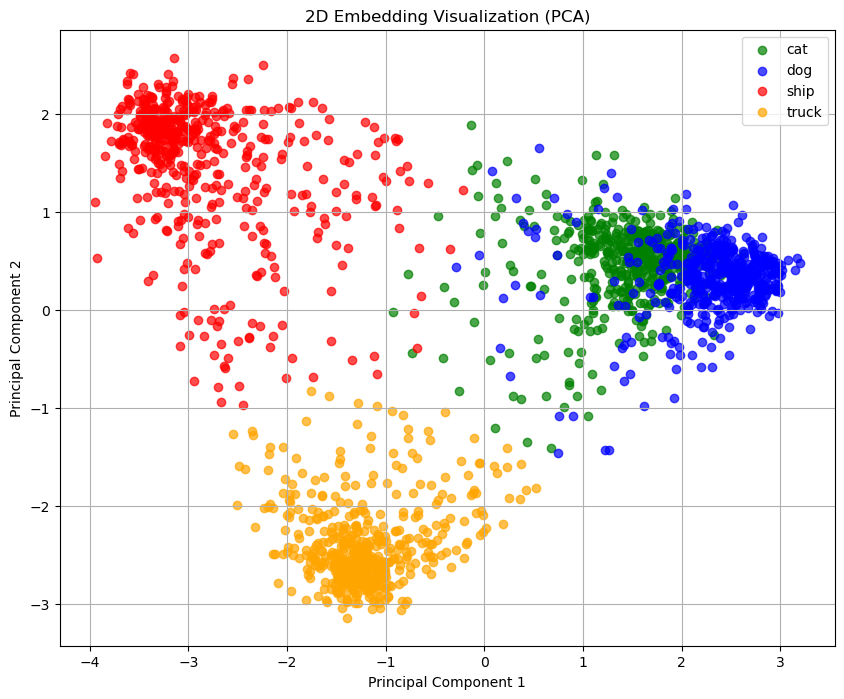

In [23]:
plt.figure(figsize=(10, 8))
for i in np.unique(labels):
    index = np.where(labels==i)[0]
    x = reduced_embeddings[index, 0]
    y = reduced_embeddings[index, 1]
    color = color_map[i]
    label = i
    plt.scatter(x, y, c=color, label=label, alpha=0.7)
plt.title("2D Embedding Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()